# Описание проекта

Интернет-магазин «В один клик» продаёт разные товары: для детей, для дома, мелкую бытовую технику, косметику и даже продукты. Отчёт магазина за прошлый период показал, что активность покупателей начала снижаться. Привлекать новых клиентов уже не так эффективно: о магазине и так знает большая часть целевой аудитории. Возможный выход — удерживать активность постоянных клиентов. Сделать это можно с помощью персонализированных предложений.
«В один клик» — современная компания, поэтому её руководство не хочет принимать решения просто так — только на основе анализа данных и бизнес-моделирования. 

Итак, требуется разработать решение, которое позволит персонализировать предложения постоянным клиентам, чтобы увеличить их покупательскую активность.

Краткий план выполнения проекта:

1) Нужно построить модель, которая предскажет вероятность снижения покупательской активности клиента в следующие три месяца

2) В исследование нужно включить дополнительные данные финансового департамента о прибыльности клиента: какой доход каждый покупатель приносил компании за последние три месяца

3) Используя данные модели и данные о прибыльности клиентов, нужно выделить сегменты покупателей и разработать для них персонализированные предложения.

In [1]:
# установим библиотеку shap для анализа важности входных признаков 

!pip install shap -q

# установим нужную версию sklearn

!pip install scikit-learn==1.1.3 -q

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

import shap

# 1) Загрузка данных

In [3]:
market_file = pd.read_csv('/datasets/market_file.csv')
market_money = pd.read_csv('/datasets/market_money.csv')
market_time = pd.read_csv('/datasets/market_time.csv')
money = pd.read_csv('/datasets/money.csv', sep=';', decimal=',')

In [4]:
market_file.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская активность            1300 non-null   object 
 2   Тип сервиса                          1300 non-null   object 
 3   Разрешить сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  Ошибка_сервиса                

In [5]:
market_file.head(10)

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2
5,215353,Снизилась,стандартт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4
6,215354,Снизилась,стандартт,да,5.1,3,431,0.23,Косметика и аксесуары,2,3,7,2
7,215355,Снизилась,стандартт,нет,4.7,4,284,0.17,Товары для детей,5,1,6,4
8,215356,Снизилась,стандартт,да,4.2,4,192,0.14,Косметика и аксесуары,2,2,1,3
9,215357,Снизилась,стандартт,да,3.9,5,154,0.00,Техника для красоты и здоровья,3,3,9,5


In [6]:
market_money.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   Период   3900 non-null   object 
 2   Выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


In [7]:
market_money.head(10)

,id,Период,Выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6
5,215349,предыдущий_месяц,5216.0
6,215350,препредыдущий_месяц,4826.0
7,215350,текущий_месяц,5058.4
8,215350,предыдущий_месяц,5457.5
9,215351,текущий_месяц,6610.4


In [8]:
market_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   Период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


In [9]:
market_time.head(10)

,id,Период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13
5,215350,предыдцщий_месяц,8
6,215351,текущий_месяц,13
7,215351,предыдцщий_месяц,11
8,215352,текущий_месяц,11
9,215352,предыдцщий_месяц,8


In [10]:
money.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   int64  
 1   Прибыль  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB


In [11]:
money.head(10)

,id,Прибыль
0,215348,0.98
1,215349,4.16
2,215350,3.13
3,215351,4.87
4,215352,4.21
5,215353,3.95
6,215354,3.62
7,215355,5.26
8,215356,4.93
9,215357,4.66


# Вывод по разделу:

1) предоставленные данные соответствуют описанию

2) заметны разного рода опечатки в значениях, которые стоит исправить в следующем разделе

# 2) Предобработка данных

Обработаем опечатки в категориальных значениях:

In [12]:
def get_unique_cat_values(df):
    for col in df.select_dtypes(include='object').columns.tolist():
        print(df[col].unique(), col)
        
get_unique_cat_values(market_file)

['Снизилась' 'Прежний уровень'] Покупательская активность
['премиум' 'стандартт' 'стандарт'] Тип сервиса
['да' 'нет'] Разрешить сообщать
['Товары для детей' 'Домашний текстиль' 'Косметика и аксесуары'
 'Техника для красоты и здоровья' 'Кухонная посуда'
 'Мелкая бытовая техника и электроника'] Популярная_категория


In [13]:
market_file['Тип сервиса'] = market_file['Тип сервиса'].replace('стандартт', 'стандарт')
market_file['Тип сервиса'].unique()

array(['премиум', 'стандарт'], dtype=object)

In [14]:
get_unique_cat_values(market_money)

['препредыдущий_месяц' 'текущий_месяц' 'предыдущий_месяц'] Период


In [15]:
get_unique_cat_values(market_time)

['текущий_месяц' 'предыдцщий_месяц'] Период


In [16]:
market_time['Период'] = market_money['Период'].replace('предыдцщий_месяц', 'предыдущий_месяц')
market_time['Период'].unique()

array(['препредыдущий_месяц', 'текущий_месяц', 'предыдущий_месяц'],
      dtype=object)

Переименуем столбцы:

In [17]:
market_file = market_file.rename(columns={'Тип сервиса': 'Тип_сервиса', 'Разрешить сообщать': 'Разрешить_сообщать'})

Обработаем пропуски:

In [18]:
market_file.isna().sum()

id                                     0
Покупательская активность              0
Тип_сервиса                            0
Разрешить_сообщать                     0
Маркет_актив_6_мес                     0
Маркет_актив_тек_мес                   0
Длительность                           0
Акционные_покупки                      0
Популярная_категория                   0
Средний_просмотр_категорий_за_визит    0
Неоплаченные_продукты_штук_квартал     0
Ошибка_сервиса                         0
Страниц_за_визит                       0
dtype: int64

In [19]:
market_money.isna().sum()

id         0
Период     0
Выручка    0
dtype: int64

In [20]:
market_time.isna().sum()

id        0
Период    0
минут     0
dtype: int64

In [21]:
money.isna().sum()

id         0
Прибыль    0
dtype: int64

Обработаем дубликаты:

In [22]:
market_file.duplicated().sum()

0

In [23]:
market_money.duplicated().sum()

0

In [24]:
market_money = market_money.drop_duplicates().reset_index(drop=True)
market_money.duplicated().sum()

0

In [25]:
market_time.duplicated().sum()

2

In [26]:
market_time = market_time.drop_duplicates().reset_index(drop=True)
market_time.duplicated().sum()

0

In [27]:
money.duplicated().sum()

0

# Вывод по разделу:

1) устранены опечатки

2) обработаны пропуски и устранены дубликаты

# 3) Исследовательский анализ данных

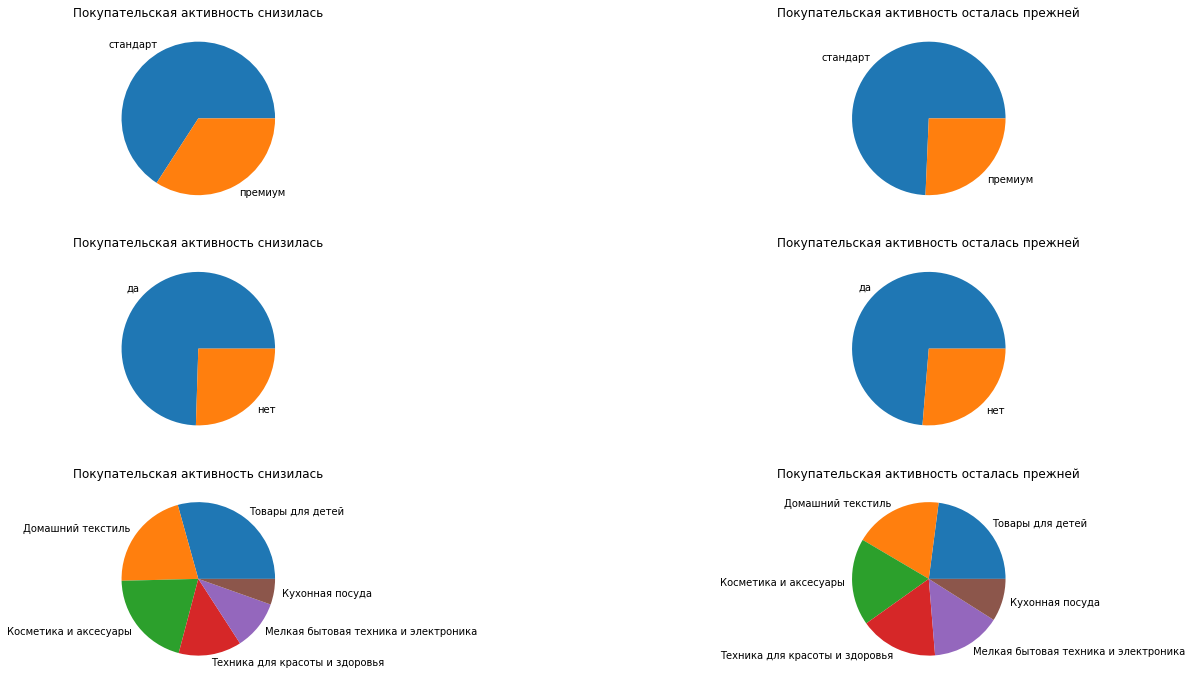

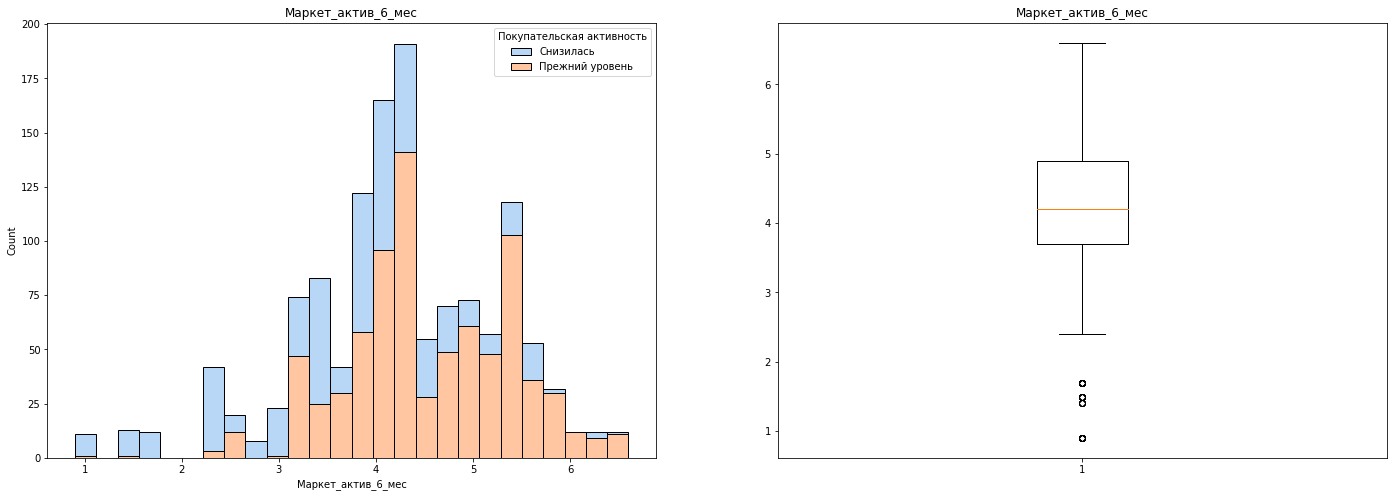

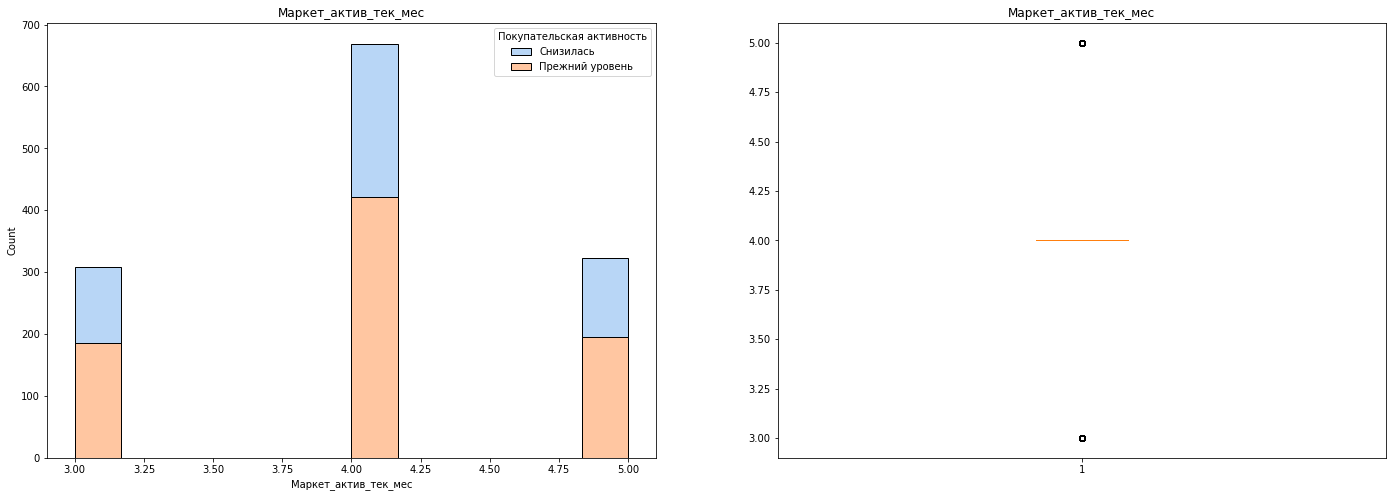

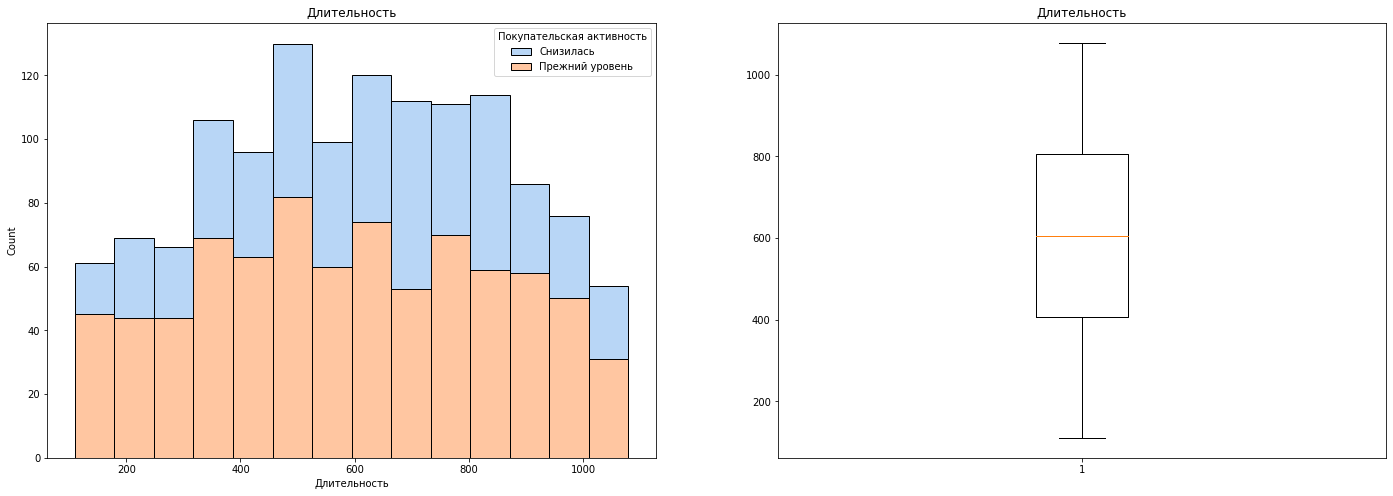

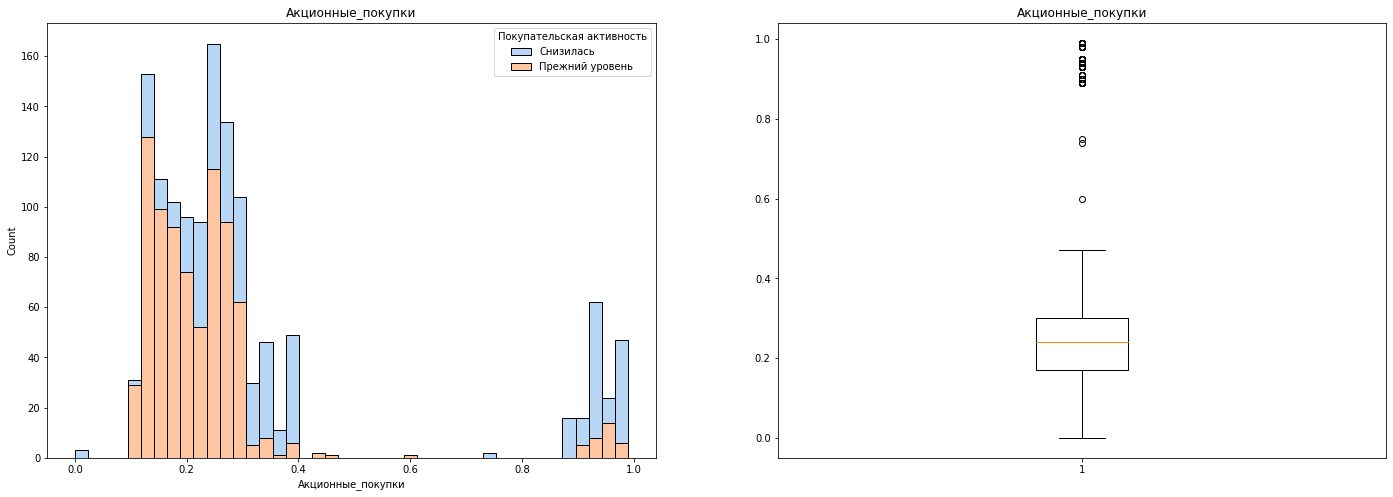

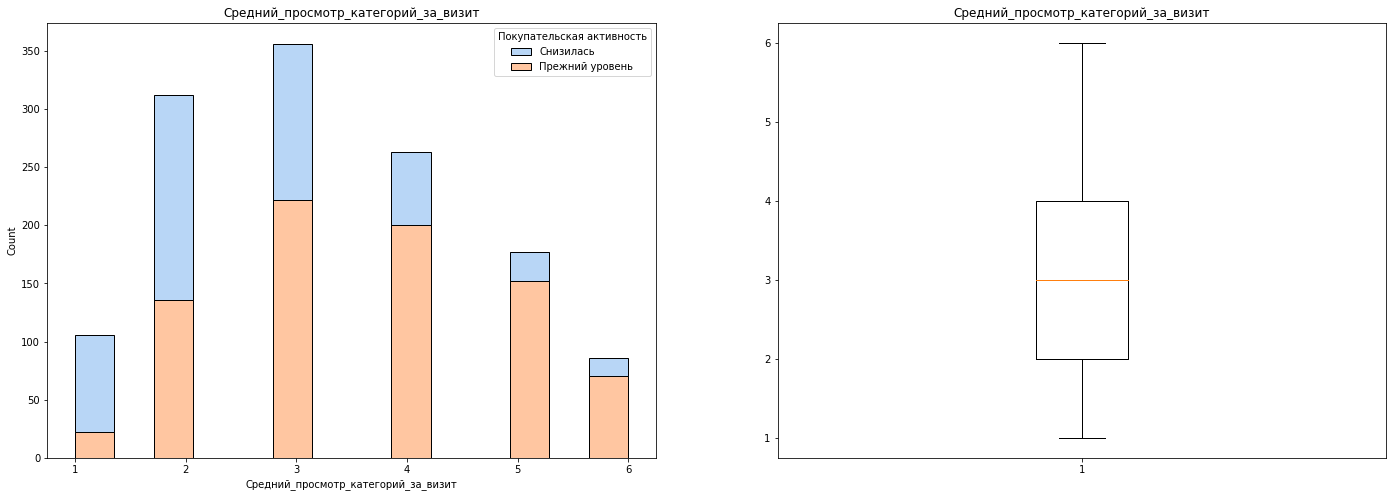

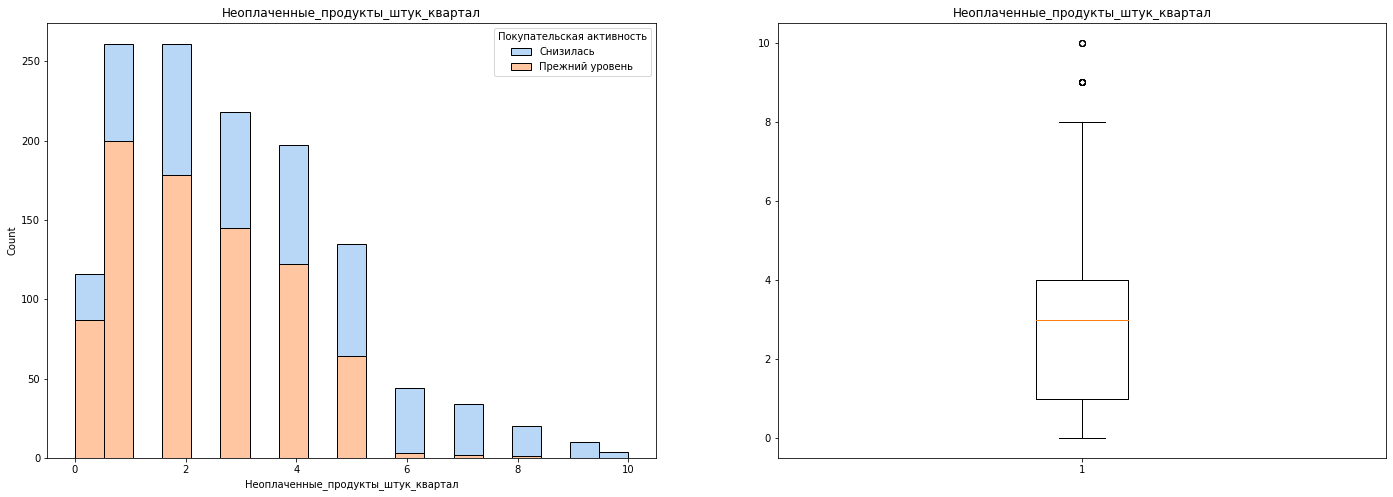

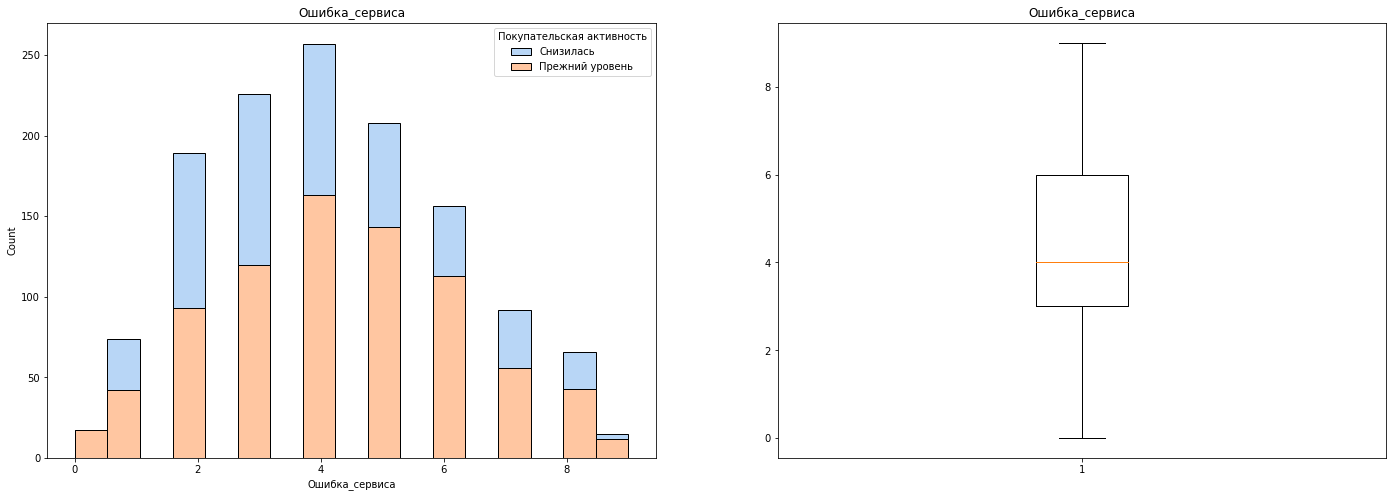

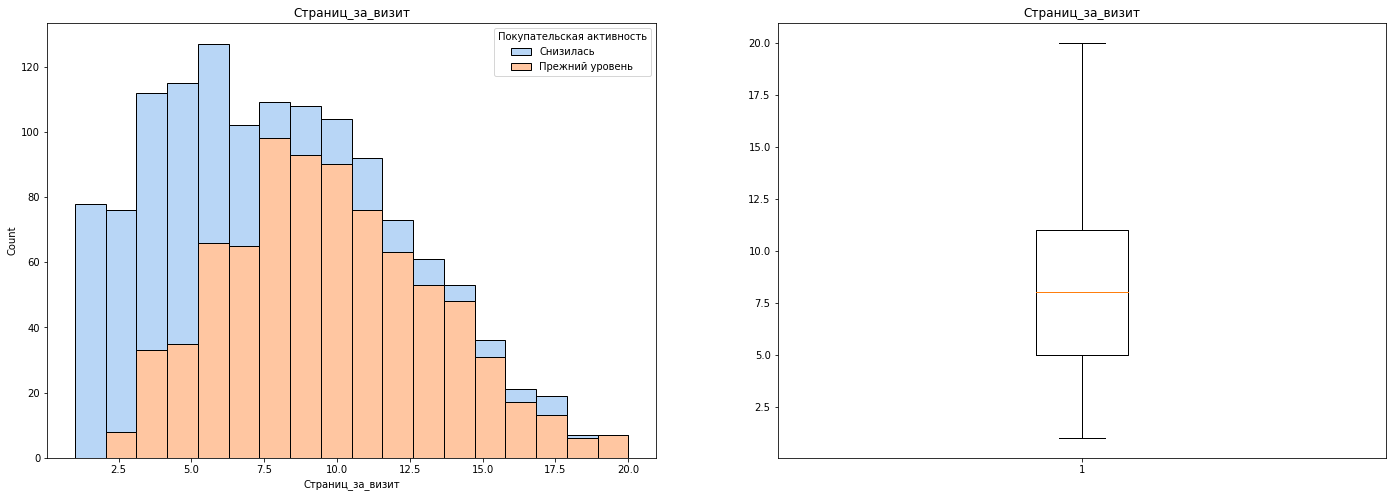

In [28]:
def get_distribution(df, hue=None):
    cat_col_names = df.select_dtypes(include='object').columns.tolist()
    num_col_names = df.select_dtypes(exclude='object').columns.tolist()
    num_col_names.remove('id')
    if 'Покупательская активность' in cat_col_names:
        cat_col_names.remove('Покупательская активность')
    
    # отображение диаграмм для категориальных данных
    if cat_col_names:
        if len(cat_col_names) > 1:
            fig, ax = plt.subplots(len(cat_col_names), 2, figsize=(24, 12))
            for i, cat_col in enumerate(cat_col_names, start=0):
                ax[i, 0].pie(df[df['Покупательская активность'] == 'Снизилась'][cat_col].value_counts().values, labels=df[cat_col].value_counts().index)
                ax[i, 1].pie(df[df['Покупательская активность'] != 'Снизилась'][cat_col].value_counts().values, labels=df[cat_col].value_counts().index)
                ax[i, 0].set_title('Покупательская активность снизилась')
                ax[i, 1].set_title('Покупательская активность осталась прежней')
        else:
            fig, ax = plt.subplots(figsize=(24, 6))
            ax.pie(df[cat_col_names[0]].value_counts().values, labels=df[cat_col_names[0]].value_counts().index)
            ax.set_title(cat_col_names[0])
        
    # отображение распределений количественных данных
    for i, num_col in enumerate(num_col_names, start=0):
        fig, ax = plt.subplots(1, 2, figsize=(24, 8))
        sns.histplot(data=df, ax=ax[0], stat="count", multiple="stack", x=num_col, kde=False, palette="pastel", hue=hue, element="bars", legend=True)
        ax[0].set_title(num_col)
        ax[1].boxplot(df[num_col])
        ax[1].set_title(num_col)
        
get_distribution(market_file, hue="Покупательская активность")

Видно, что в столбце `Акционные_покупки` есть выбросы. Значит есть пользователи, среди заказов которых почти все акционные. Кроме того, можно заметить дисбаланс классов у целевого признака `Покупательская активность`, значит при обучении моделей стоит использовать стратифицированную выборку

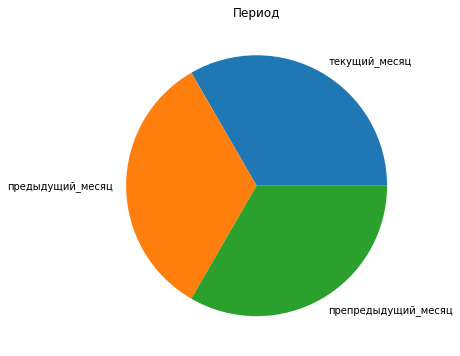

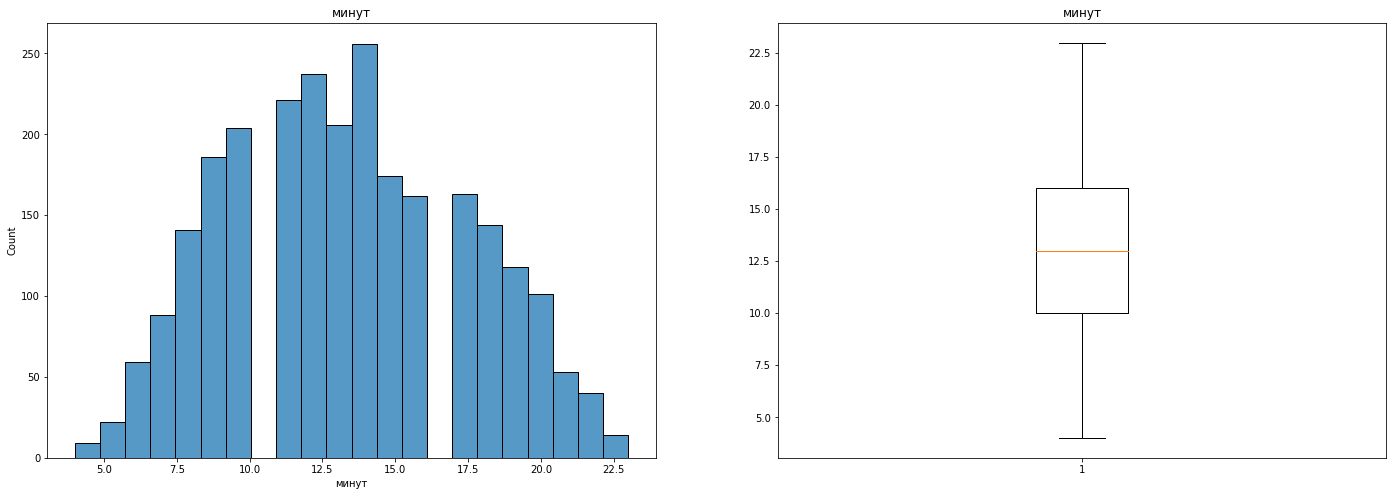

In [29]:
get_distribution(market_time)

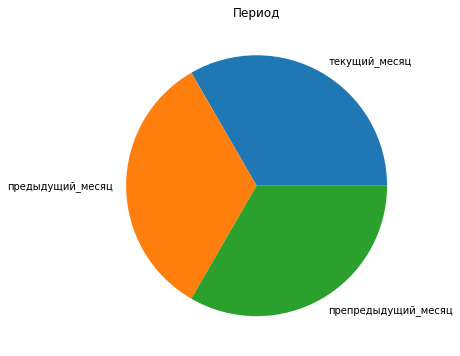

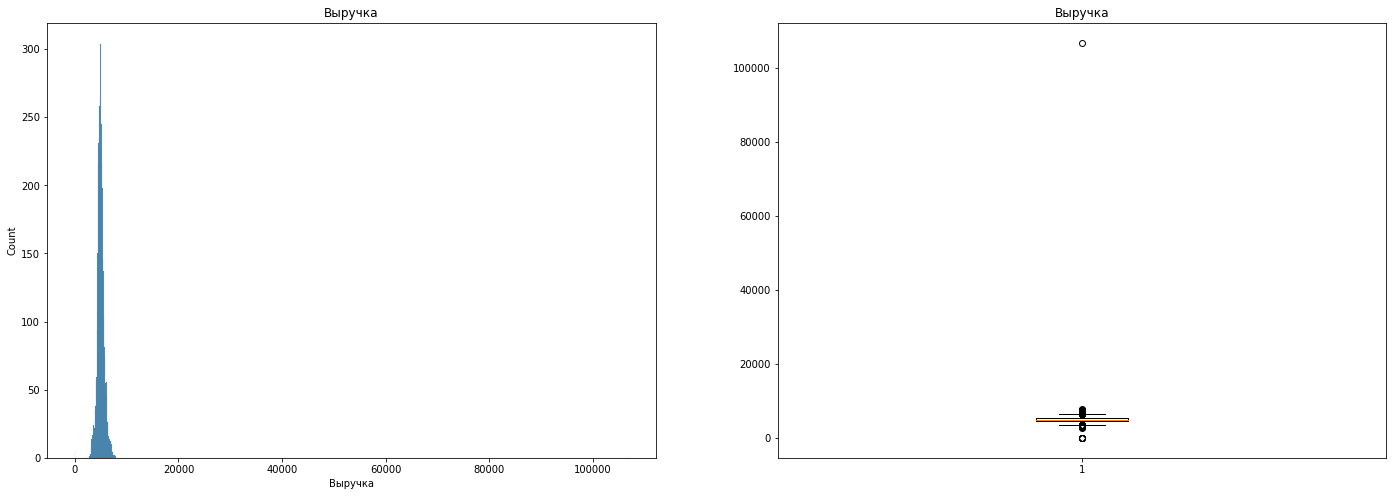

In [30]:
get_distribution(market_money)

Видно, что есть выброс (значение выручки >100.000). Изучим это:

In [31]:
market_money[market_money['Выручка'] > 100000]

,id,Период,Выручка
98,215380,текущий_месяц,106862.2


Такой случай возможен в жизни, вероятно клиент приобрёл много дорогих товаров по акции:

In [32]:
market_file[market_file['id'] == 215380]

,id,Покупательская активность,Тип_сервиса,Разрешить_сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
32,215380,Снизилась,премиум,нет,1.7,4,637,0.94,Техника для красоты и здоровья,3,2,4,7


Видно, что доля акционных покупок составляет 94% от всех заказов, причём товары из категории `техника для красоты и здоровья`, вероятно моя теория подтвердилась :)

В качестве одной из моделей для решения задачи классификации будет использована чувствительная к выбросам `логистическая регрессия`, поэтому стоит избавиться от него:

In [33]:
market_file = market_file[~market_file['id'].isin([215380])]
market_money = market_money[~market_money['id'].isin([215380])]
market_time = market_time[~market_time['id'].isin([215380])]
money = money[~money['id'].isin([215380])]

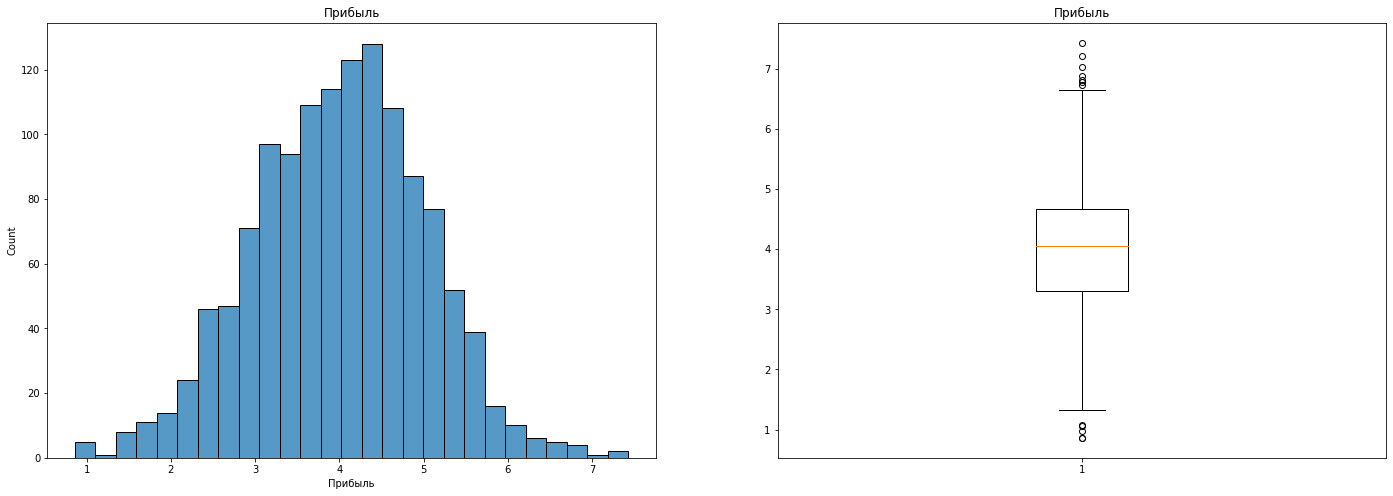

In [34]:
get_distribution(money)

Отберём клиентов с покупательской активностью не менее трёх месяцев, то есть таких, которые что-либо покупали в этот период:

In [35]:
ids = money[money['Прибыль'] > 0]['id']
market_file = market_file[market_file['id'].isin(ids)]
market_time = market_time[market_time['id'].isin(ids)]
market_money = market_money[market_money['id'].isin(ids)]
money = money[money['id'].isin(ids)]

# Вывод по разделу:

1) были построены распределения для всех данных

2) удалены выбросы, но не все, так как некоторые из них информативны и просто так удалить их нельзя

3) отобраны клиенты с покупательской активностью не менее трёх месяцев

# 4) Объединение таблиц

Для начала учтём, что данные о выручке и времени на сайте находятся в одном столбце для всех периодов. В итоговой таблице сделаем отдельный столбец для каждого периода:

In [36]:
# Пропущенные значения заменим на 0
market_money = market_money.pivot_table(index='id', columns='Период', values='Выручка', fill_value=0)
market_money.columns = ['выручка_за_' + col for col in market_money.columns]
market_money

,выручка_за_предыдущий_месяц,выручка_за_препредыдущий_месяц,выручка_за_текущий_месяц
id,,,
215348,0.0,0,3293.1
215349,5216.0,4472,4971.6
215350,5457.5,4826,5058.4
215351,6158.0,4793,6610.4
215352,5807.5,4594,5872.5
...,...,...,...
216643,3664.0,4704,4741.7
216644,4729.0,5299,5353.0
216645,5160.0,5334,5139.2


In [37]:
# Пропущенные значения заменим на 0
market_time = market_time.pivot_table(index='id', columns='Период', values='минут', fill_value=0)
market_time.columns = ['минут_за_' + col for col in market_time.columns]
market_time

,минут_за_предыдущий_месяц,минут_за_препредыдущий_месяц,минут_за_текущий_месяц
id,,,
215348,0.0,14.0,13.0
215349,10.0,12.0,0.0
215350,8.0,0.0,13.0
215351,0.0,13.0,11.0
215352,11.0,0.0,8.0
...,...,...,...
216643,14.0,0.0,7.0
216644,11.0,12.0,0.0
216645,0.0,0.0,15.0


In [38]:
market_file.shape

(1299, 13)

У всех датафреймов одинаковое количество строк - можно смело объединить в их один итоговый датафрейм!

In [39]:
market_df = market_file.join(market_money, on='id').join(market_time, on='id')
market_df

,id,Покупательская активность,Тип_сервиса,Разрешить_сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,выручка_за_предыдущий_месяц,выручка_за_препредыдущий_месяц,выручка_за_текущий_месяц,минут_за_предыдущий_месяц,минут_за_препредыдущий_месяц,минут_за_текущий_месяц
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5,0.0,0,3293.1,0.0,14.0,13.0
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,5216.0,4472,4971.6,10.0,12.0,0.0
2,215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,5457.5,4826,5058.4,8.0,0.0,13.0
3,215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,6158.0,4793,6610.4,0.0,13.0,11.0
4,215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,5807.5,4594,5872.5,11.0,0.0,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1295,216643,Прежний уровень,стандарт,да,6.6,3,318,0.24,Техника для красоты и здоровья,5,3,3,11,3664.0,4704,4741.7,14.0,0.0,7.0
1296,216644,Прежний уровень,стандарт,нет,5.1,4,454,0.21,Домашний текстиль,6,2,3,9,4729.0,5299,5353.0,11.0,12.0,0.0
1297,216645,Прежний уровень,стандарт,да,4.1,3,586,0.20,Домашний текстиль,3,2,5,7,5160.0,5334,5139.2,0.0,0.0,15.0
1298,216646,Прежний уровень,стандарт,да,6.3,5,645,0.12,Техника для красоты и здоровья,3,3,5,7,4923.0,4725,5224.6,7.0,18.0,0.0


# Вывод по разделу:

1) были преобразованы датафреймы `market_time` и `market_money` к виду, удобному для объединения

2) датафреймы `market_file`, `market_time` и `market_money` были объединены в датафрейм market_df

# 5) Корреляционный анализ

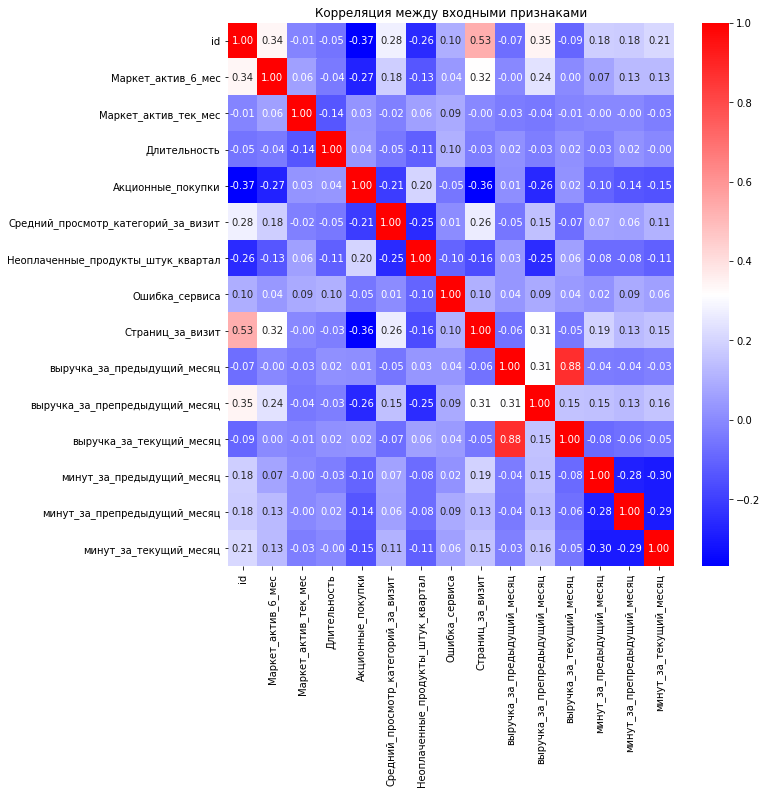

In [40]:
corr = market_df.corr(method='spearman')

fig, ax = plt.subplots(figsize=(10, 10)) 
sns.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values, annot=True, fmt='.2f', cmap="bwr", ax=ax).set(title='Корреляция между входными признаками')
plt.show()

# Вывод по разделу:

1) проанализирована корреляция входных признаков


 # 6) Использование пайплайнов

В качестве метрики, оценивающей качество моделей я выбрал метрику ROC-AUC. ROC-кривая учитывает не только результаты классификации, но и вероятность предсказания всех классов

In [41]:
RANDOM_STATE = 7
TEST_SIZE = 0.25

X, y = market_df.drop(['id', 'Покупательская активность'], axis=1), market_df['Покупательская активность']

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE,
    stratify = y)

# создаём списки с названиями признаков
ohe_columns = X_train.select_dtypes(include='object').columns.tolist()
num_columns = X_train.select_dtypes(exclude='object').columns.tolist()

ohe_pipe = Pipeline(
    [('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False))
    ])

# создаём общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('num', MinMaxScaler(), num_columns)
    ]
)

# создаём итоговый пайплайн: подготовка данных и модель
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

param_grid = [
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 5),
        'models__max_features': range(2, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough'],
        'preprocessor__ohe': [OrdinalEncoder(), OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False)]
    },
    
    # словарь для модели KNeighborsClassifier() 
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough'],
        'preprocessor__ohe': [OrdinalEncoder(), OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False)]  
    },

    # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE, 
            solver='liblinear', 
            penalty='l1'
        )],
        'models__C': range(1, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough'],
        'preprocessor__ohe': [OrdinalEncoder(), OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False)]  
    },
    
    # словарь для модели SVC()
    {
        'models': [SVC(kernel='poly', random_state=RANDOM_STATE, probability=True)],
        'models__degree': range(1, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough'],
        'preprocessor__ohe': [OrdinalEncoder(), OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False)]  
    }
]

randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
)
randomized_search.fit(X_train, y_train)

print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print('Метрика лучшей модели на тренировочной выборке:', randomized_search.best_score_)

y_test_pred = randomized_search.predict_proba(X_test)[:, 1]

print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(y_test, y_test_pred)}')

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('ohe',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse=False),
                                                  ['Тип_сервиса',
                                                   'Разрешить_сообщать',
                                                   'Популярная_категория']),
                                                 ('num', StandardScaler(),
                                                  ['Маркет_актив_6_мес',
                                                   'Маркет_актив_тек_мес',
                                                   'Длительность',
                                                   'Акционные_покупки',
                                                   'Ср

In [42]:
market_df['Вероятность_снижения_покупательской_активности'] = randomized_search.predict_proba(X)[:, 1]
market_df.head(10)

,id,Покупательская активность,Тип_сервиса,Разрешить_сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,выручка_за_предыдущий_месяц,выручка_за_препредыдущий_месяц,выручка_за_текущий_месяц,минут_за_предыдущий_месяц,минут_за_препредыдущий_месяц,минут_за_текущий_месяц,Вероятность_снижения_покупательской_активности
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5,0.0,0,3293.1,0.0,14.0,13.0,0.915642
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,5216.0,4472,4971.6,10.0,12.0,0.0,0.931420
2,215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,5457.5,4826,5058.4,8.0,0.0,13.0,0.398124
3,215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,6158.0,4793,6610.4,0.0,13.0,11.0,0.839589
4,215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,5807.5,4594,5872.5,11.0,0.0,8.0,0.973104
5,215353,Снизилась,стандарт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4,4738.5,5124,5388.5,10.0,10.0,0.0,0.516187
6,215354,Снизилась,стандарт,да,5.1,3,431,0.23,Косметика и аксесуары,2,3,7,2,5685.0,4503,5869.6,11.0,12.0,0.0,0.758320
7,215355,Снизилась,стандарт,нет,4.7,4,284,0.17,Товары для детей,5,1,6,4,3263.0,4749,3772.6,10.0,0.0,12.0,0.206463
8,215356,Снизилась,стандарт,да,4.2,4,192,0.14,Косметика и аксесуары,2,2,1,3,4146.5,4433,4566.4,0.0,6.0,7.0,0.912319
9,215357,Снизилась,стандарт,да,3.9,5,154,0.00,Техника для красоты и здоровья,3,3,9,5,0.0,0,5986.3,12.0,0.0,6.0,0.934966


# Вывод по разделу:

1) составлен пайплайн, который кодирует категориальные признаки, масштабирует количественные, а затем обучает модели и выявляет среди них лучшую по наивысшему значению метрики ROC-AUC

2) Лучшей моделью оказалась модель LogisticRegression(C=2, penalty='l1', random_state=7, solver='liblinear'), метрика ROC-AUC на тренировочной выборке ~0.899, на тестовой - ~0.912

# 7) Анализ важности признаков

Изучим лучшую модель более подробно:

In [43]:
randomized_search.best_estimator_[0]

ColumnTransformer(transformers=[('ohe',
                                 OneHotEncoder(drop='first',
                                               handle_unknown='ignore',
                                               sparse=False),
                                 ['Тип_сервиса', 'Разрешить_сообщать',
                                  'Популярная_категория']),
                                ('num', StandardScaler(),
                                 ['Маркет_актив_6_мес', 'Маркет_актив_тек_мес',
                                  'Длительность', 'Акционные_покупки',
                                  'Средний_просмотр_категорий_за_визит',
                                  'Неоплаченные_продукты_штук_квартал',
                                  'Ошибка_сервиса', 'Страниц_за_визит',
                                  'выручка_за_предыдущий_месяц',
                                  'выручка_за_препредыдущий_месяц',
                                  'выручка_за_текущий_месяц',
                                  'минут_за_предыдущий_месяц',
                                  'минут_за_препредыдущий_месяц',
                                  'минут_за_текущий_месяц'])])

In [44]:
randomized_search.best_estimator_[0].transformers_[0][1].get_feature_names_out()

array(['Тип_сервиса_стандарт', 'Разрешить_сообщать_нет',
       'Популярная_категория_Косметика и аксесуары',
       'Популярная_категория_Кухонная посуда',
       'Популярная_категория_Мелкая бытовая техника и электроника',
       'Популярная_категория_Техника для красоты и здоровья',
       'Популярная_категория_Товары для детей'], dtype=object)

In [45]:
randomized_search.best_estimator_[0].transformers_[1][1].get_feature_names_out()

array(['Маркет_актив_6_мес', 'Маркет_актив_тек_мес', 'Длительность',
       'Акционные_покупки', 'Средний_просмотр_категорий_за_визит',
       'Неоплаченные_продукты_штук_квартал', 'Ошибка_сервиса',
       'Страниц_за_визит', 'выручка_за_предыдущий_месяц',
       'выручка_за_препредыдущий_месяц', 'выручка_за_текущий_месяц',
       'минут_за_предыдущий_месяц', 'минут_за_препредыдущий_месяц',
       'минут_за_текущий_месяц'], dtype=object)

Составим тестовую и тренировочные выборки (понадобятся для вычисления значений Шепли)

In [46]:
X_train_p = pd.DataFrame(
    randomized_search.best_estimator_[0].fit_transform(X_train),
    columns=randomized_search.best_estimator_[0].transformers_[0][1].get_feature_names_out().tolist() + \
            randomized_search.best_estimator_[0].transformers_[1][1].get_feature_names_out().tolist()
)

X_test_p = pd.DataFrame(
    randomized_search.best_estimator_[0].transform(X_test),
    columns=randomized_search.best_estimator_[0].transformers_[0][1].get_feature_names_out().tolist() + \
            randomized_search.best_estimator_[0].transformers_[1][1].get_feature_names_out().tolist()
)

X_test_p

,Тип_сервиса_стандарт,Разрешить_сообщать_нет,Популярная_категория_Косметика и аксесуары,Популярная_категория_Кухонная посуда,Популярная_категория_Мелкая бытовая техника и электроника,Популярная_категория_Техника для красоты и здоровья,Популярная_категория_Товары для детей,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,...,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,выручка_за_предыдущий_месяц,выручка_за_препредыдущий_месяц,выручка_за_текущий_месяц,минут_за_предыдущий_месяц,минут_за_препредыдущий_месяц,минут_за_текущий_месяц
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,-0.243856,1.413459,0.342574,...,-0.226825,-0.427267,-1.130918,0.947782,-0.679343,-0.549905,-0.949767,1.136577,0.585604,-1.216866
1,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.638008,-0.026613,1.052111,...,-0.226825,-0.935397,-0.113353,-0.052369,0.391560,0.080748,0.531167,-1.237666,0.585604,0.592642
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.421887,-0.026613,0.787538,...,1.241130,0.588992,0.904212,-0.802483,-0.820629,-0.089899,-1.371869,1.276238,-1.243885,0.314256
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.929750,-0.026613,1.356772,...,-0.226825,0.080863,-0.113353,1.197820,-0.300534,0.051070,-0.583642,1.555561,1.148524,-1.216866
4,1.0,0.0,0.0,1.0,0.0,0.0,0.0,-1.125720,-0.026613,-0.687658,...,-0.226825,-1.443526,1.412995,-1.552597,-1.110708,-0.745284,-0.830663,-1.237666,-0.399505,-0.242516
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
320,1.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.733780,-1.466686,-0.118425,...,-0.226825,-1.443526,-0.113353,0.697744,1.753908,1.539907,0.536884,-1.237666,0.585604,1.010221
321,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.148084,1.413459,-0.038251,...,-0.226825,1.097122,-0.113353,1.697896,-0.778312,-0.159148,-0.466325,1.136577,1.007794,-1.216866
322,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-1.321689,-1.466686,1.893936,...,0.507153,1.097122,0.395430,0.197669,-1.811675,0.513550,-0.764084,-1.237666,0.304144,0.314256
323,1.0,0.0,0.0,1.0,0.0,0.0,0.0,-0.145871,-0.026613,-1.549526,...,1.241130,0.080863,-1.639701,-0.302407,0.902099,0.575378,1.156222,-1.237666,0.585604,1.566992


Построим диаграмму важности каждого из входных признаков:

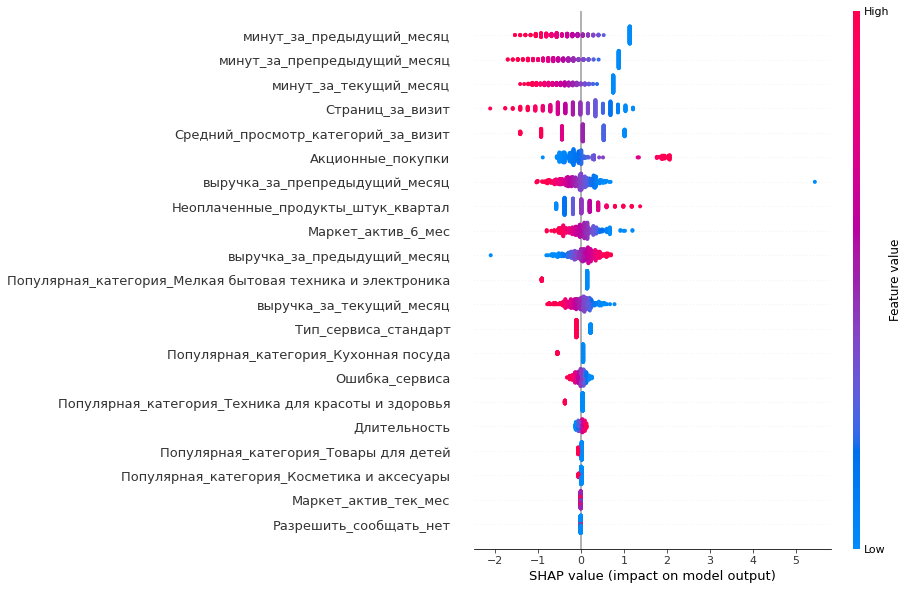

In [47]:
explainer = shap.LinearExplainer(randomized_search.best_estimator_[1], X_test_p)
shap_values = explainer(X_test_p)
shap.plots.beeswarm(shap_values, max_display=50)

# Вывод по разделу:

1) Построена диаграмма важности входных признаков

2) наиболее важными являются следующие признаки: `минут_за_предыдущий_месяц`, `минут_за_текущий_месяц`, `Страниц_за_визит`, `минут_за_препредыдущий_месяц`, `Средний_просмотр_категорий_за_визит`

3) наименее важными являются следующие признаки: `Популярная_категория`, `Длительность`, `Разрешить сообщать`, `Маркет_актив_тек_мес`

4) При моделировании имеет смысл не учитывать малозначимые признаки, что даст прирост к производительности обучения

# 8) Сегментация покупателей

Выделим группу клиентов, которые покупают только технику, то есть товары с длинным жизненным циклом (эти покупатели важны, так как техника в целом стоит дороже остальных позиицй, следовательно приносит большую прибыль компании):

In [48]:
market_df['Популярная_категория'].unique()

array(['Товары для детей', 'Домашний текстиль', 'Косметика и аксесуары',
       'Техника для красоты и здоровья', 'Кухонная посуда',
       'Мелкая бытовая техника и электроника'], dtype=object)

In [49]:
money.shape, market_df.shape

((1299, 2), (1299, 20))

Выделим сегмент (на основе популярной категории и вероятности снижения покупательской активности >= 0.75):

In [50]:
segment = market_df[(market_df['Популярная_категория'].isin(['Техника для красоты и здоровья', 'Мелкая бытовая техника и электроника']))].merge(money, on='id')
segment.head()

,id,Покупательская активность,Тип_сервиса,Разрешить_сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,...,Ошибка_сервиса,Страниц_за_визит,выручка_за_предыдущий_месяц,выручка_за_препредыдущий_месяц,выручка_за_текущий_месяц,минут_за_предыдущий_месяц,минут_за_препредыдущий_месяц,минут_за_текущий_месяц,Вероятность_снижения_покупательской_активности,Прибыль
0,215357,Снизилась,стандарт,да,3.9,5,154,0.00,Техника для красоты и здоровья,3,...,9,5,0.0,0,5986.3,12.0,0.0,6.0,0.934966,4.66
1,215361,Снизилась,стандарт,да,5.1,4,199,0.23,Техника для красоты и здоровья,4,...,2,3,6400.0,4597,3789.7,13.0,0.0,11.0,0.785184,4.03
2,215365,Снизилась,стандарт,да,3.9,4,167,0.95,Техника для красоты и здоровья,6,...,2,5,4577.0,4190,4799.3,10.0,6.0,0.0,0.914585,3.65
3,215368,Снизилась,премиум,да,3.8,5,829,0.24,Техника для красоты и здоровья,2,...,6,1,5823.0,4536,5591.6,0.0,11.0,9.0,0.921543,6.27
4,215378,Снизилась,стандарт,да,1.7,3,488,0.39,Техника для красоты и здоровья,5,...,4,3,3543.0,4302,4364.6,8.0,12.0,0.0,0.687690,3.03


Проанализируем клиентов из этого сегмента:

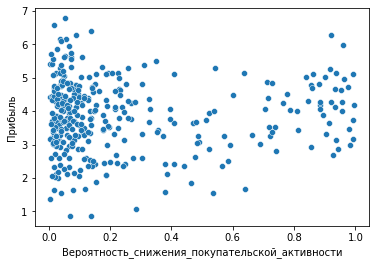

In [51]:
sns.scatterplot(data=segment, x='Вероятность_снижения_покупательской_активности', y='Прибыль')
plt.show()

Из графика видно, что в качетсве границы по вероятности снижения покупательской активности стоит выбрать значение 0.7, а в качестве прибыли возьмём порог 2.5, тогда мы сможем проанализировать довольно прибыльных клиентов, у которых высока верояность снижения покупательской активности (расположены в правом верхнем прямоугольнике):

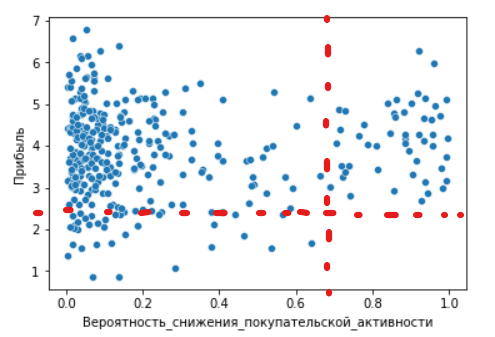

In [52]:
segment = segment[(segment['Вероятность_снижения_покупательской_активности'] >= 0.7) & (segment['Прибыль'] >= 2.5)]

Исследуем сегмент более подробно, а именно рассмотрим распределение прибыли в разрезе различных признаков:

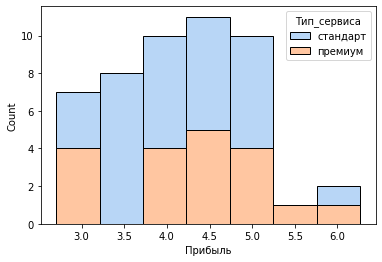

In [53]:
sns.histplot(data=segment, stat="count", multiple="stack", x='Прибыль', kde=False, palette="pastel", hue='Тип_сервиса', element="bars", legend=True)
plt.show()

Видно, что подавляющее большинство клиентов пользуются стандартным типом сервиса, возможно стоит предложить им премиумный тип подписки со скидкой или же на бесплатный период, например на 30 дней

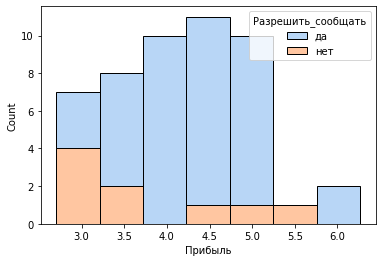

In [54]:
sns.histplot(data=segment, stat="count", multiple="stack", x='Прибыль', kde=False, palette="pastel", hue='Разрешить_сообщать', element="bars", legend=True)
plt.show()

У большинства клиентов разрешены уведомления с предложениями о покупке товаров, поэтому данный признак не является сильнозначимым, но всё же стоит попробовать увеличить число таких клиентов (например разослать письма с предложением разрешить рассылку тем, кто ещё этого не сделал)

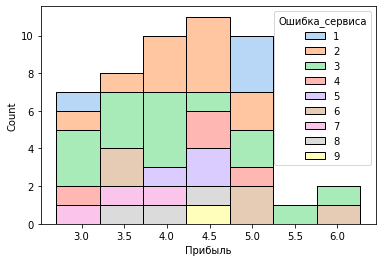

In [55]:
sns.histplot(data=segment, stat="count", multiple="stack", x='Прибыль', kde=False, palette="pastel", hue='Ошибка_сервиса', element="bars", legend=True)
plt.show()

У большинства клиентов не более трёх ошибок сервиса, поэтому это не является сильной проблемой, которая влияет на снижение покупательской активности

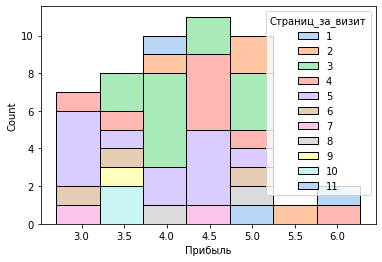

In [56]:
sns.histplot(data=segment, stat="count", multiple="stack", x='Прибыль', kde=False, palette="pastel", hue='Страниц_за_визит', element="bars", legend=True)
plt.show()

Большинство клиентов посещает не более 3-4 страницы за визит, возможно, дело в том, что они не находят нужный им товар, поэтому стоит попробовать разнообразить набор предоставляемых на продажу товаров

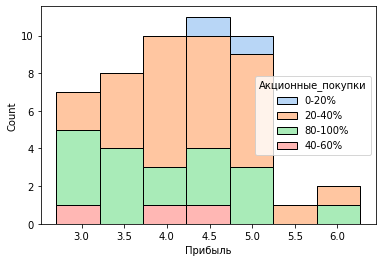

In [57]:
def categorize(x):
    if 0 <= x < 0.2:
        return '0-20%'
    if 0.2 <= x < 0.4:
        return '20-40%'
    if 0.4 <= x < 0.6:
        return '40-60%'
    if 0.6 <= x < 0.8:
        return '60-80%'
    return '80-100%'

sns.histplot(data=segment, stat="count", multiple="stack", x='Прибыль', kde=False, palette="pastel", hue=segment['Акционные_покупки'].apply(categorize), element="bars", legend=True)
plt.show()

У большинства клиентов доля акционных покупок составляет от 20 до 40%, возможно, стоит чаще проводить акционные мероприятия. Уточним на какую категорию товаров стоит сделать акцент:

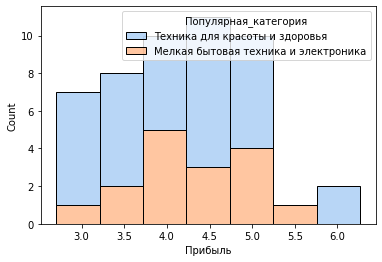

In [58]:
sns.histplot(data=segment, stat="count", multiple="stack", x='Прибыль', kde=False, palette="pastel", hue='Популярная_категория', element="bars", legend=True)
plt.show()

Видно, что бо́льшая часть купленных товаров принадлежит категории `Техника для красоты и здоровья`, поэтому стоит проводить акции на товары из категории `Мелкая бытовая техника и электроника`

# Вывод по разделу:

1) Выделен и проанализирован сегмент пользователей, которые покупают только технику, то есть товары с длинным жизненным циклом

2) Даны рекомендации по удержанию таких пользователей

# Итоговый вывод:

Интернет-магазин «В один клик» продаёт разные товары: для детей, для дома, мелкую бытовую технику, косметику и даже продукты. Отчёт магазина за прошлый период показал, что активность покупателей начала снижаться. Привлекать новых клиентов уже не так эффективно: о магазине и так знает большая часть целевой аудитории. Возможный выход — удерживать активность постоянных клиентов. Сделать это можно с помощью персонализированных предложений.

Для решения этой задачи требуется разработать модель, которая предскажет вероятность снижения покупательской активности.
Так же надо выделить сегмент покупателей, проанализировать его и предложить, как увеличить покупательскую активность.

Этапы решения задачи:

В нашем распоряжении были таблицы `market_file.csv`, `market_money.csv`, `market_time.csv` и `money.csv`
1) Обработка и анализ данных: 

    - устранены опечатки
    - обработаны пропуски и устранены дубликаты
    - были построены распределения для всех данных
    - удалены выбросы
    - отобраны клиенты с покупательской активностью не менее трёх месяцев
    - проанализирована корреляция входных признаков
2) Поиск лучшей модели:

    - Для решения задачи были использованы четыре модели: KNeighborsClassifier, DecisionTreeClassifier, LogisticRegression и  SVC
    - составлен пайплайн, который кодирует категориальные признаки, масштабирует количественные, а затем обучает модели и выявляет среди них лучшую по наивысшему значению метрики ROC-AUC
    - Лучшей моделью оказалась модель LogisticRegression(C=2, penalty='l1', random_state=7, solver='liblinear'), метрика ROC-AUC на тренировочной выборке ~0.899, на тестовой - ~0.912
3) Сегментация покупателей и их анализ:

    - В качестве рассматриваемого сегмента была выбрана группа клиентов, которые покупают только технику, то есть товары с длинным жизненным циклом
    - Среди сегментированных покупателей, у которых снизилась покупательская активность, преобладает стандартный тип сервиса, поэтому для увеличения потенциальной прибыли имеет смысл предложить таким клиентам премиумный тип сервиса
    - Стоит увеличить количество пользователей, которым можно отправлять рассылку с предложениями о покупке товаров
    - Стоит разнообразить набор предоставляемых на продажу товаров
    - Имеет смысл проводить различного рода акции на товары из категории `Мелкая бытовая техника и электроника`